In [10]:
# dependencies
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore FutureWarnings from KMeans algorithm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [11]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
# Check for missing data in the datasets
print("For train dataset:\n",train.isnull().sum(),"\n")
print("For test dataset:\n",test.isnull().sum())

For train dataset:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

For test dataset:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [13]:
# As we can see, some columns have missing data, such as "Age", "Cabin", "Fare" and "Embarked". 
# We'll try to impute missing data. Firstly, let's find out types of features

In [14]:
print("Feature data types in the datasets:")
print(train.dtypes)

Feature data types in the datasets:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [15]:
# "Age", "Fare", "Embarked" is numerical and "Cabin" is categorical

# Thus, we will use the mean value for "Age" and "Fare", the most frequent value for "Embarked", 
# and a new category for "Cabin" where the data is missing

In [16]:
# Impute Age and Fare
train['Age'].fillna(train['Age'].mean(), inplace=True)
train['Fare'].fillna(train['Fare'].mean(), inplace=True)

test['Age'].fillna(test['Age'].mean(), inplace=True)
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

# Impute Embarked
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)

# Impute Cabin
train['Cabin'] = train['Cabin'].fillna('Unknown')
test['Cabin'] = test['Cabin'].fillna('Unknown')

In [17]:
# Clustering algorithms require numerical data, so we need to encode categorical variables.
# We will use one-hot encoding for "Sex" and "Embarked", and label encoding for "Cabin"


# Fit the encoder to the training data and transform both training and test data
cabin_encoder = LabelEncoder()
cabin_encoder.fit(train['Cabin'])
train['Cabin'] = cabin_encoder.transform(train['Cabin'])
test['Cabin'] = test['Cabin'].apply(lambda x: cabin_encoder.transform([x])[0] if x in cabin_encoder.classes_ else cabin_encoder.transform(['Unknown'])[0])

# One-hot encode Sex and Embarked
train = pd.get_dummies(train, columns=['Sex', 'Embarked'])
test = pd.get_dummies(test, columns=['Sex', 'Embarked'])


In [18]:
# We can remove columns that are not needed for clustering, such as "PassengerId", "Name", "Ticket", 
# and "Survived" (since this is the target variable).

train.drop(['PassengerId', 'Name', 'Ticket', 'Survived'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [19]:
# The silhouette score measures how similar a data point is to its own cluster compared to the closest neighbor cluster. 
# The silhouette ranges from −1 to +1.

# The best value is 1, and a value close to 1 means that the sample’s distance to the nearest neighbor cluster 
# is much larger than the intra-cluster distance.

# 0 indicate overlapping clusters.

# The worst value is -1, and a value close to -1 means that the sample is assigned to the wrong cluster.

In [31]:
def cluster_data(data, n_clusters, algorithm):
    # Perform clustering
    if algorithm == 'KMeans':
        cluster_model = KMeans(n_clusters=n_clusters, random_state=42)
    elif algorithm == 'Agglomerative':
        cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
    else:
        raise ValueError('Invalid algorithm specified')

    cluster_model.fit(data)
    labels = cluster_model.labels_

    # Calculate Silhouette Score
    score = silhouette_score(data, labels, metric='euclidean')
    print(f"Silhouette Score for {algorithm} algorithm with {n_clusters} clusters: {score:.3f}\n")
    
    # Calculate the mean value of each variable within each cluster
    print("Profiling clusters...\n",data.groupby(cluster_model.labels_).mean())

    return labels

Silhouette Score for KMeans algorithm with 2 clusters: 0.714

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  36.237027  0.486301  0.438356  104.711587   59.910959   
1  2.565101  28.417863  0.530201  0.370470   17.994708  144.625503   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.506849  0.493151    0.472603    0.013699    0.513699  
1    0.322148  0.677852    0.132886    0.100671    0.766443  


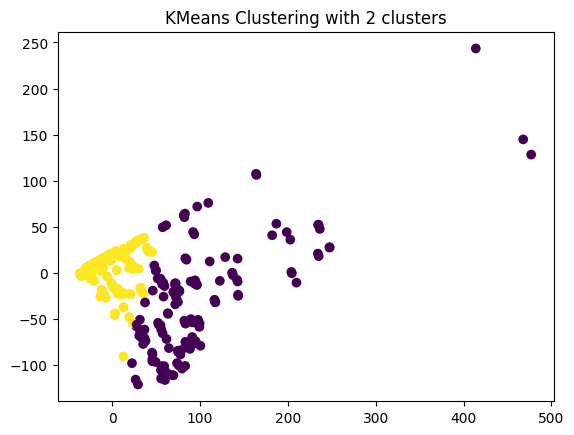

Silhouette Score for KMeans algorithm with 3 clusters: 0.709

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  37.236422  0.462121  0.340909   74.243467   59.643939   
1  2.577808  28.317061  0.527740  0.370771   18.007633  145.255751   
2  1.000000  31.019912  0.750000  1.050000  279.308545   63.800000   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.469697  0.530303    0.416667    0.015152    0.568182  
1    0.324763  0.675237    0.136671    0.101488    0.761840  
2    0.600000  0.400000    0.600000    0.000000    0.400000  


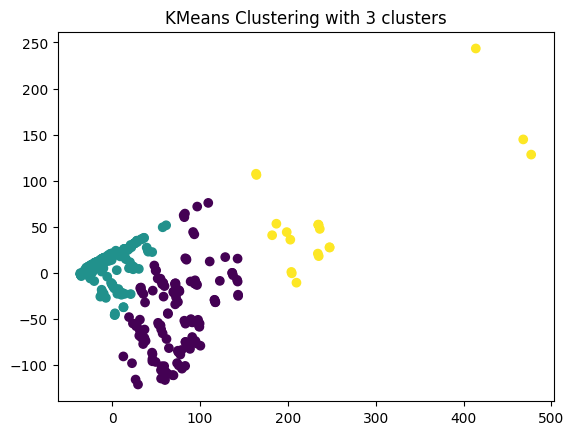

Silhouette Score for KMeans algorithm with 4 clusters: 0.708

Profiling clusters...
     Pclass        Age     SibSp     Parch        Fare       Cabin  Sex_female  \
0  2.58209  28.262290  0.529172  0.371777   17.986136  145.394844    0.322931   
1  1.00000  38.007667  0.448276  0.284483   62.236497   54.965517    0.431034   
2  1.00000  35.333333  0.000000  0.333333  512.329200   65.333333    0.333333   
3  1.00000  31.934756  0.685714  0.914286  190.907020   79.000000    0.714286   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.677069    0.137042    0.101764    0.761194  
1  0.568966    0.422414    0.017241    0.560345  
2  0.666667    1.000000    0.000000    0.000000  
3  0.285714    0.428571    0.000000    0.571429  


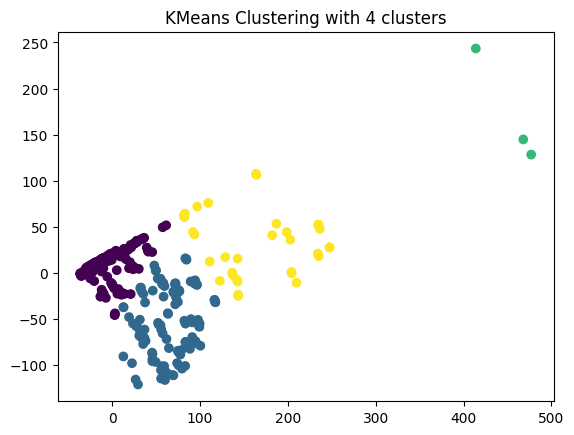

Silhouette Score for KMeans algorithm with 5 clusters: 0.649

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.384615  35.174560  1.219780  0.439560   79.736766  120.296703   
1  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
2  1.000000  37.785600  0.298701  0.285714   53.145888   36.207792   
3  1.000000  30.852495  0.703704  1.111111  205.843052   62.592593   
4  2.632035  28.012295  0.451659  0.356421   14.792093  145.558442   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.505495  0.494505    0.384615    0.021978    0.593407  
1    0.333333  0.666667    1.000000    0.000000    0.000000  
2    0.363636  0.636364    0.363636    0.000000    0.636364  
3    0.703704  0.296296    0.444444    0.000000    0.555556  
4    0.317460  0.682540    0.129870    0.108225    0.761905  


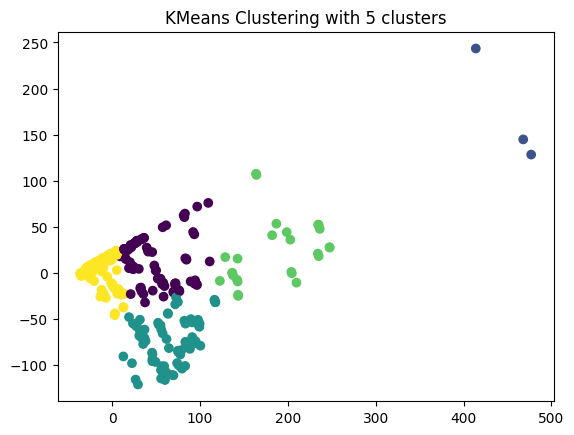

Silhouette Score for KMeans algorithm with 6 clusters: 0.596

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.653846  27.892192  0.421598  0.340237   14.160237  145.928994   
1  1.000000  33.927253  0.707317  0.658537  121.481398   84.097561   
2  1.000000  38.485791  0.267606  0.183099   48.534039   34.619718   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.578313  34.492590  1.421687  0.590361   61.551857  128.469880   
5  1.000000  30.258720  0.882353  1.176471  238.187253   63.529412   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.318047  0.681953    0.133136    0.110947    0.755917  
1    0.634146  0.365854    0.463415    0.048780    0.487805  
2    0.338028  0.661972    0.366197    0.000000    0.633803  
3    0.333333  0.666667    1.000000    0.000000    0.000000  
4    0.445783  0.554217    0.253012    0.000000    0.746988  
5    0.647059  0.352941    0.529412    0.000000    0

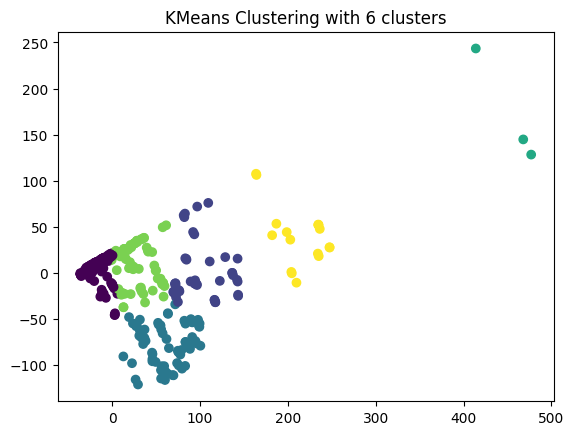

Silhouette Score for KMeans algorithm with 7 clusters: 0.433

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.666093  30.860540  0.240964  0.213425   12.289872  145.910499   
1  1.000000  38.485791  0.267606  0.183099   48.534039   34.619718   
2  1.000000  30.258720  0.882353  1.176471  238.187253   63.529412   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.000000  33.927253  0.707317  0.658537  121.481398   84.097561   
5  1.493333  35.922478  1.226667  0.506667   63.277388  126.493333   
6  2.563107  10.619877  1.660194  1.135922   27.134993  146.116505   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.283993  0.716007    0.122203    0.122203    0.755594  
1    0.338028  0.661972    0.366197    0.000000    0.633803  
2    0.647059  0.352941    0.529412    0.000000    0.470588  
3    0.333333  0.666667    1.000000    0.000000    0.000000  
4    0.634146  0.365854    0.463415    0.048

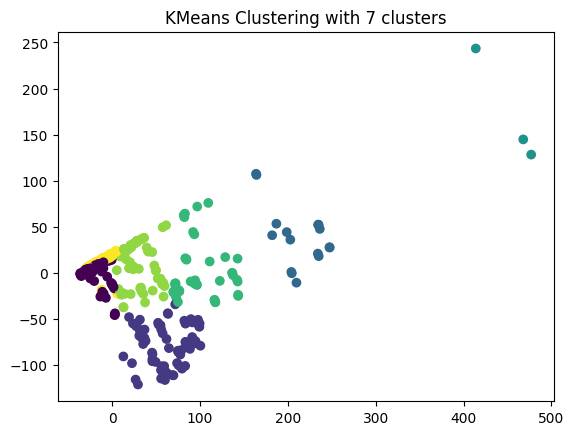

Silhouette Score for KMeans algorithm with 8 clusters: 0.444

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.062500  39.072825  0.520833  0.145833   58.621446   88.791667   
1  2.668394  30.738641  0.243523  0.203800   12.249070  146.202073   
2  1.000000  30.258720  0.882353  1.176471  238.187253   63.529412   
3  1.000000  38.566015  0.258065  0.209677   49.296037   29.725806   
4  1.000000  32.332846  0.645161  0.838710  132.556848   85.290323   
5  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
6  1.759259  34.120125  1.500000  0.722222   63.701230  141.648148   
7  2.608247   9.612878  1.731959  1.195876   26.765508  146.061856   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.500000  0.500000    0.375000    0.041667    0.583333  
1    0.281520  0.718480    0.119171    0.122625    0.758204  
2    0.647059  0.352941    0.529412    0.000000    0.470588  
3    0.354839  0.645161    0.387097 

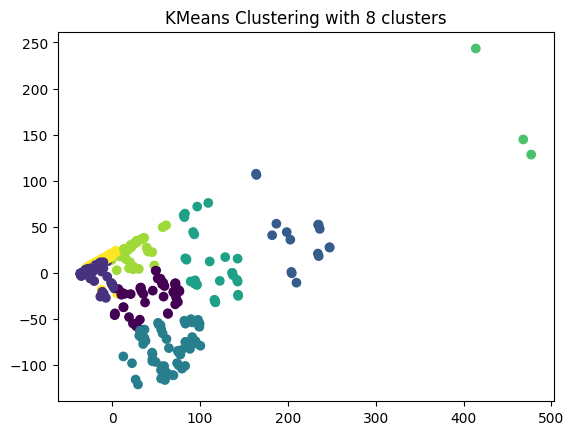

Silhouette Score for KMeans algorithm with 9 clusters: 0.428

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.819905  26.285525  0.184834  0.104265    9.614740  146.620853   
1  1.000000  38.566015  0.258065  0.209677   49.296037   29.725806   
2  1.000000  32.332846  0.645161  0.838710  132.556848   85.290323   
3  1.000000  30.258720  0.882353  1.176471  238.187253   63.529412   
4  1.063830  39.287140  0.531915  0.148936   59.230413   88.297872   
5  2.632184   8.336207  1.839080  1.310345   27.229406  145.954023   
6  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
7  1.740000  33.089735  1.580000  0.640000   65.673578  141.500000   
8  2.255814  41.449887  0.424419  0.482558   20.048110  144.959302   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.270142  0.729858    0.135071    0.142180    0.722749  
1    0.354839  0.645161    0.387097    0.000000    0.612903  
2    0.645161  0.354839    0

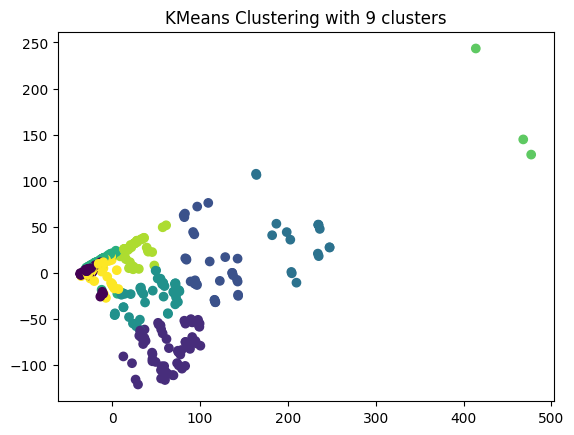

Silhouette Score for KMeans algorithm with 10 clusters: 0.437

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  37.959956  0.750000  0.300000   83.012710   90.225000   
1  2.206897  41.626895  0.385057  0.477011   20.349353  142.339080   
2  1.000000  29.513275  1.000000  1.333333  239.608887   52.400000   
3  1.000000  38.521303  0.257143  0.185714   48.100954   34.157143   
4  1.000000  30.041275  0.533333  1.200000  141.614160   59.133333   
5  2.600000   8.791667  1.788889  1.288889   27.337314  145.455556   
6  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
7  1.000000  35.109735  0.500000  0.200000  155.428330  142.700000   
8  1.770833  33.412243  1.645833  0.666667   64.475777  141.958333   
9  2.819249  26.428384  0.194836  0.100939    9.626231  146.772300   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.550000  0.450000    0.575000    0.050000    0.375000  
1    0.333333  0.66

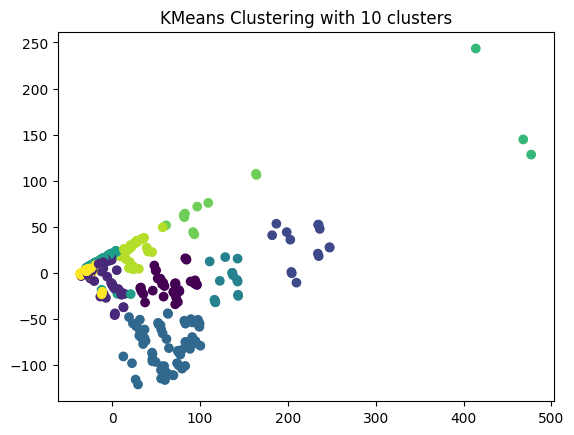

Silhouette Score for Agglomerative algorithm with 2 clusters: 0.710

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  35.384482  0.434426  0.491803  108.633265   53.459016   
1  2.516255  28.797148  0.537061  0.364109   20.078922  143.005202   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0     0.47541   0.52459    0.450820     0.00000    0.549180  
1     0.33290   0.66710    0.146944     0.10013    0.752926  


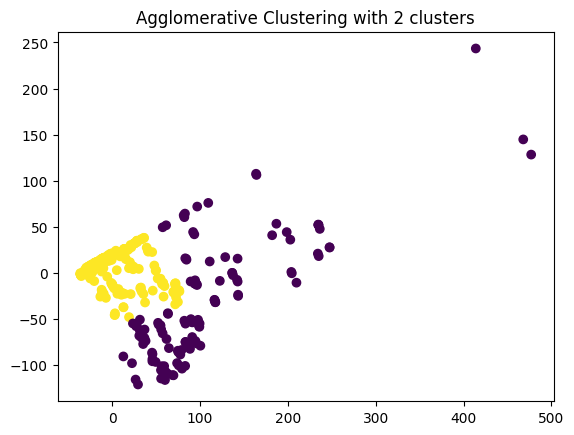

Silhouette Score for Agglomerative algorithm with 3 clusters: 0.696

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  31.743690  0.660377  0.886792  187.032858   79.509434   
1  2.516255  28.797148  0.537061  0.364109   20.078922  143.005202   
2  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.641509  0.358491    0.547170     0.00000    0.452830  
1    0.332900  0.667100    0.146944     0.10013    0.752926  
2    0.347826  0.652174    0.376812     0.00000    0.623188  


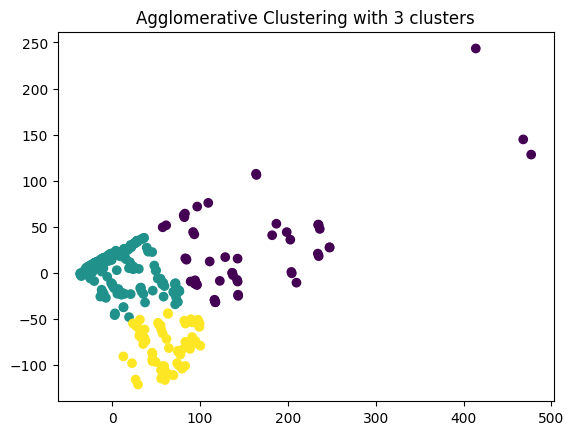

Silhouette Score for Agglomerative algorithm with 4 clusters: 0.704

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.516255  28.797148  0.537061  0.364109   20.078922  143.005202   
1  1.000000  31.528312  0.700000  0.920000  167.515078   80.360000   
2  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.332900  0.667100    0.146944     0.10013    0.752926  
1    0.660000  0.340000    0.520000     0.00000    0.480000  
2    0.347826  0.652174    0.376812     0.00000    0.623188  
3    0.333333  0.666667    1.000000     0.00000    0.000000  


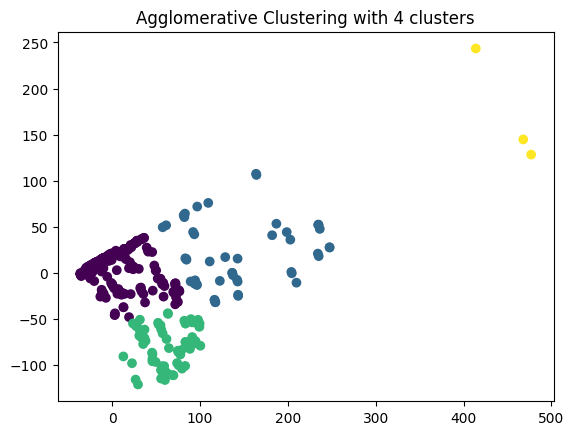

Silhouette Score for Agglomerative algorithm with 5 clusters: 0.611

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  31.528312  0.700000  0.920000  167.515078   80.360000   
1  2.630592  27.987764  0.448773  0.356421   14.755945  145.396825   
2  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.473684  36.177457  1.342105  0.434211   68.616063  121.197368   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.660000  0.340000    0.520000    0.000000    0.480000  
1    0.317460  0.682540    0.129870    0.108225    0.761905  
2    0.347826  0.652174    0.376812    0.000000    0.623188  
3    0.333333  0.666667    1.000000    0.000000    0.000000  
4    0.473684  0.526316    0.302632    0.026316    0.671053  


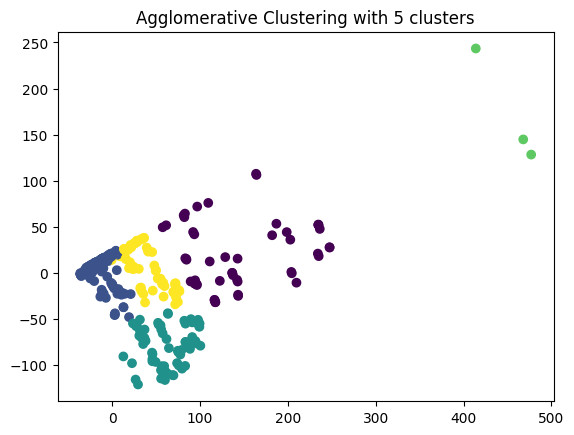

Silhouette Score for Agglomerative algorithm with 6 clusters: 0.619

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.630592  27.987764  0.448773  0.356421   14.755945  145.396825   
1  1.473684  36.177457  1.342105  0.434211   68.616063  121.197368   
2  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.000000  32.391899  0.571429  0.742857  136.617731   92.342857   
5  1.000000  29.513275  1.000000  1.333333  239.608887   52.400000   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.317460  0.682540    0.129870    0.108225    0.761905  
1    0.473684  0.526316    0.302632    0.026316    0.671053  
2    0.347826  0.652174    0.376812    0.000000    0.623188  
3    0.333333  0.666667    1.000000    0.000000    0.000000  
4    0.657143  0.342857    0.542857    0.000000    0.457143  
5    0.666667  0.333333    0.466667    0.0000

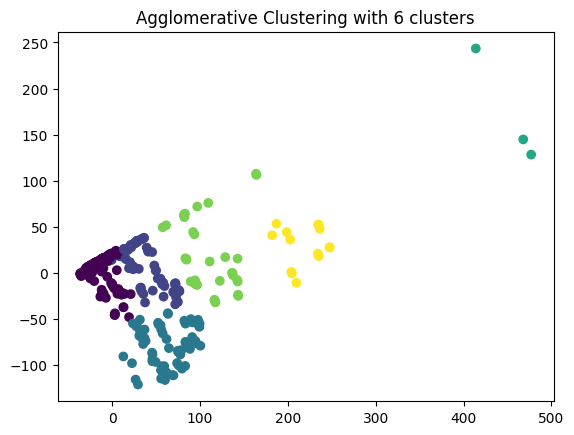

Silhouette Score for Agglomerative algorithm with 7 clusters: 0.371

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.473684  36.177457  1.342105  0.434211   68.616063  121.197368   
1  1.000000  32.391899  0.571429  0.742857  136.617731   92.342857   
2  2.220657  38.886743  0.431925  0.511737   20.876507  142.061033   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  2.812500  23.151342  0.456250  0.287500   12.039946  146.877083   
5  1.000000  29.513275  1.000000  1.333333  239.608887   52.400000   
6  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.473684  0.526316    0.302632    0.026316    0.671053  
1    0.657143  0.342857    0.542857    0.000000    0.457143  
2    0.366197  0.633803    0.107981    0.056338    0.835681  
3    0.333333  0.666667    1.000000    0.000000    0.000000  
4    0.295833  0.704167    0.139583  

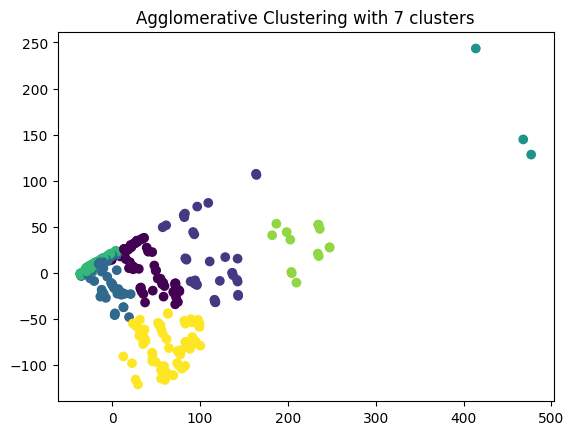

Silhouette Score for Agglomerative algorithm with 8 clusters: 0.368

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  32.391899  0.571429  0.742857  136.617731   92.342857   
1  2.812500  23.151342  0.456250  0.287500   12.039946  146.877083   
2  2.220657  38.886743  0.431925  0.511737   20.876507  142.061033   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.800000  34.068634  1.755556  0.600000   64.244718  141.622222   
5  1.000000  29.513275  1.000000  1.333333  239.608887   52.400000   
6  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
7  1.000000  39.238653  0.741935  0.193548   74.961565   91.548387   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.657143  0.342857    0.542857    0.000000    0.457143  
1    0.295833  0.704167    0.139583    0.131250    0.729167  
2    0.366197  0.633803    0.107981    0.056338    0.835681  
3    0.333333  0.666667    1.

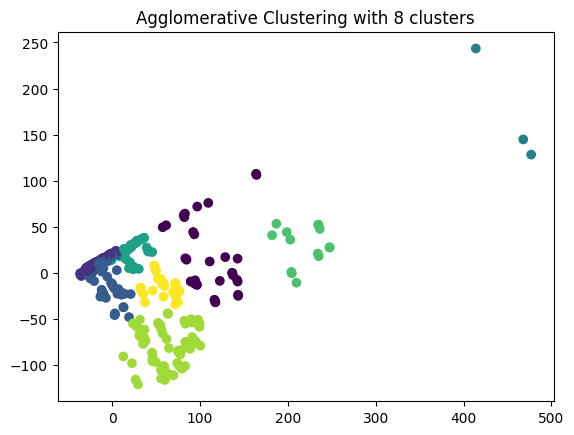

Silhouette Score for Agglomerative algorithm with 9 clusters: 0.376

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.812500  23.151342  0.456250  0.287500   12.039946  146.877083   
1  1.000000  34.645214  0.454545  0.181818  150.973482  143.090909   
2  2.220657  38.886743  0.431925  0.511737   20.876507  142.061033   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.800000  34.068634  1.755556  0.600000   64.244718  141.622222   
5  1.000000  29.513275  1.000000  1.333333  239.608887   52.400000   
6  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
7  1.000000  39.238653  0.741935  0.193548   74.961565   91.548387   
8  1.000000  31.359130  0.625000  1.000000  130.038013   69.083333   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.295833  0.704167    0.139583    0.131250    0.729167  
1    0.727273  0.272727    0.636364    0.000000    0.363636  
2    0.366197  0.6338

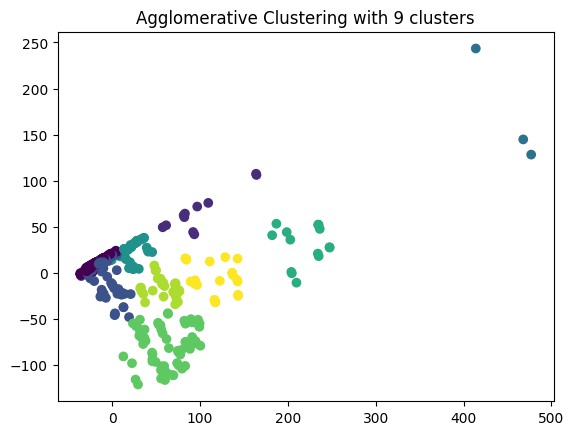

Silhouette Score for Agglomerative algorithm with 10 clusters: 0.420

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.220657  38.886743  0.431925  0.511737   20.876507  142.061033   
1  1.000000  34.645214  0.454545  0.181818  150.973482  143.090909   
2  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.800000  34.068634  1.755556  0.600000   64.244718  141.622222   
5  1.000000  29.513275  1.000000  1.333333  239.608887   52.400000   
6  2.826406  26.137883  0.176039  0.090465    9.373267  146.909535   
7  1.000000  39.238653  0.741935  0.193548   74.961565   91.548387   
8  1.000000  31.359130  0.625000  1.000000  130.038013   69.083333   
9  2.732394   5.947183  2.070423  1.422535   27.401525  146.690141   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.366197  0.633803    0.107981    0.056338    0.835681  
1    0.72727

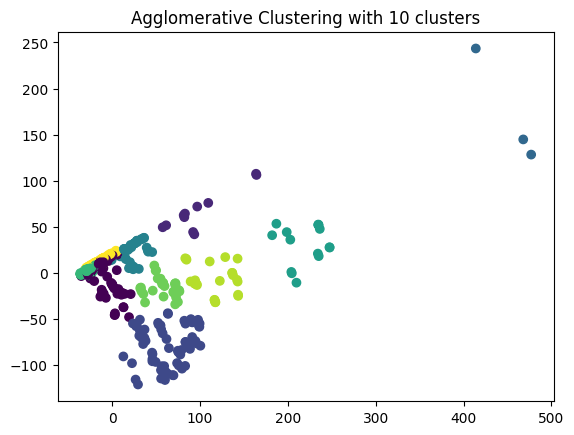

In [32]:
# PCA is used for dimensionality reduction 
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train)

# KMeans clustering
for n_clusters in range(2, 11):
    cluster_labels = cluster_data(train, n_clusters=n_clusters, algorithm='KMeans')
    plt.scatter(train_pca[:, 0], train_pca[:, 1], c=cluster_labels)
    plt.title(f"KMeans Clustering with {n_clusters} clusters")
    plt.show()

# Agglomerative Clustering
for n_clusters in range(2, 11):
    cluster_labels = cluster_data(train, n_clusters=n_clusters, algorithm='Agglomerative')
    plt.scatter(train_pca[:, 0], train_pca[:, 1], c=cluster_labels)
    plt.title(f"Agglomerative Clustering with {n_clusters} clusters")
    plt.show()


In [33]:
# Using both KMeans and Agglomerative algorithms, the proper numbers of clusters are probably 2, 3 or 4 clusters 
# based on the highest silhouette score values and cluster profiling.

# That's why we'll use these numbers of clusters for clustering test dataset

Silhouette Score for KMeans algorithm with 2 clusters: 0.802

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.359897  29.481858  0.429306  0.359897   22.499213  142.316195   
1  1.000000  40.879310  0.689655  0.827586  211.723138  105.896552   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.347044  0.652956    0.213368    0.118252    0.668380  
1    0.586207  0.413793    0.655172    0.000000    0.344828  


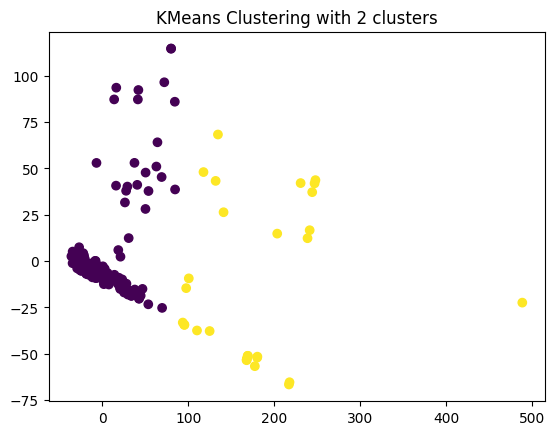

Silhouette Score for Agglomerative algorithm with 2 clusters: 0.802

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.359897  29.481858  0.429306  0.359897   22.499213  142.316195   
1  1.000000  40.879310  0.689655  0.827586  211.723138  105.896552   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.347044  0.652956    0.213368    0.118252    0.668380  
1    0.586207  0.413793    0.655172    0.000000    0.344828  


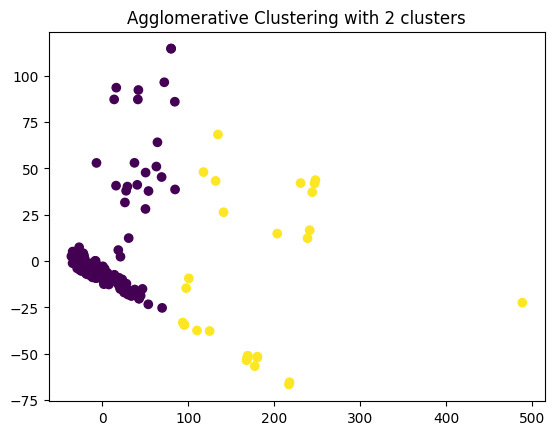

Silhouette Score for KMeans algorithm with 3 clusters: 0.703

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.477654  28.283360  0.405028  0.357542   18.260353  146.670391   
1  1.000000  43.805556  0.777778  1.000000  252.662506  102.444444   
2  1.000000  41.428571  0.666667  0.428571   90.643652   97.142857   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.326816  0.673184    0.192737    0.125698    0.681564  
1    0.666667  0.333333    0.666667    0.000000    0.333333  
2    0.547619  0.452381    0.500000    0.023810    0.476190  


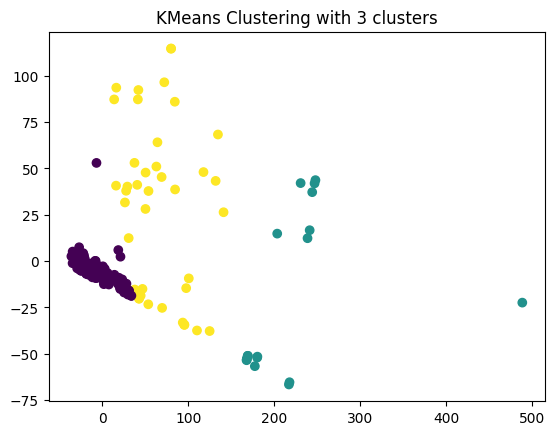

Silhouette Score for Agglomerative algorithm with 3 clusters: 0.641

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  40.879310  0.689655  0.827586  211.723138  105.896552   
1  1.285714  38.002420  0.875000  0.750000   66.155730  114.946429   
2  2.540541  28.048971  0.354354  0.294294   15.157576  146.918919   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.586207  0.413793    0.655172    0.000000    0.344828  
1    0.500000  0.500000    0.446429    0.017857    0.535714  
2    0.321321  0.678679    0.174174    0.135135    0.690691  


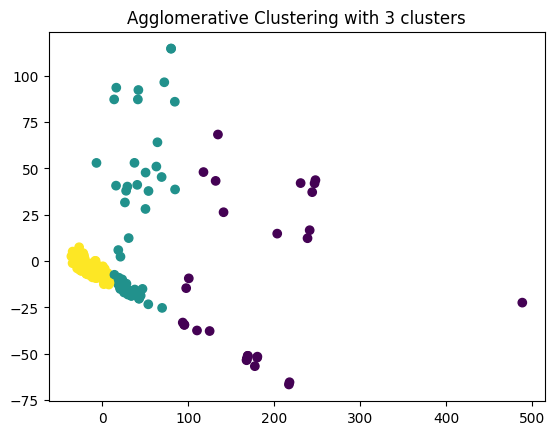

Silhouette Score for KMeans algorithm with 4 clusters: 0.653

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.537538  28.019759  0.351351  0.276276   15.061918  146.747748   
1  1.000000  43.805556  0.777778  1.000000  252.662506  102.444444   
2  1.000000  45.200000  0.800000  0.440000   79.577996   66.080000   
3  1.404762  33.449118  0.857143  1.023810   79.504074  144.500000   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.321321  0.678679    0.177177    0.135135    0.687688  
1    0.666667  0.333333    0.666667    0.000000    0.333333  
2    0.640000  0.360000    0.400000    0.040000    0.560000  
3    0.404762  0.595238    0.500000    0.000000    0.500000  


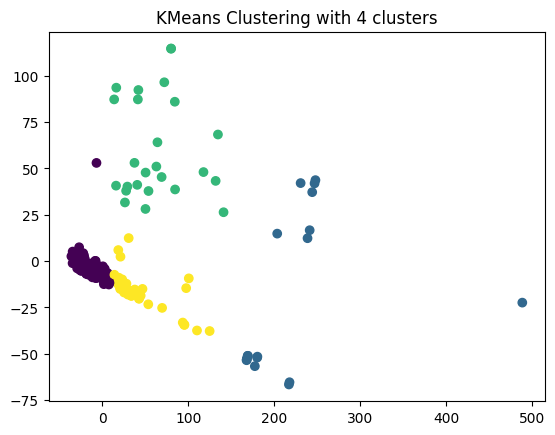

Silhouette Score for Agglomerative algorithm with 4 clusters: 0.646

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.285714  38.002420  0.875000  0.750000   66.155730  114.946429   
1  1.000000  42.750000  1.250000  2.000000  287.562500   46.750000   
2  2.540541  28.048971  0.354354  0.294294   15.157576  146.918919   
3  1.000000  40.166667  0.476190  0.380952  182.831952  128.428571   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.500000  0.500000    0.446429    0.017857    0.535714  
1    0.625000  0.375000    0.750000    0.000000    0.250000  
2    0.321321  0.678679    0.174174    0.135135    0.690691  
3    0.571429  0.428571    0.619048    0.000000    0.380952  


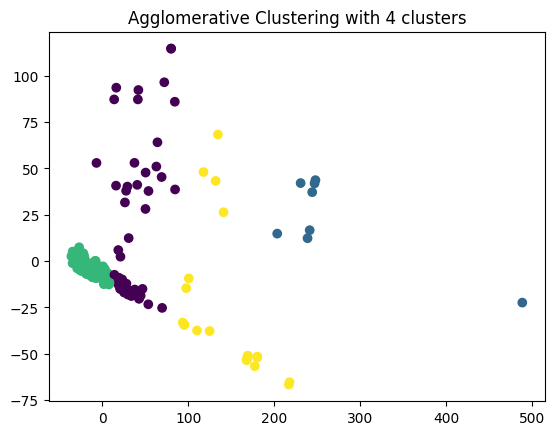

In [34]:
# PCA is used for dimensionality reduction 
pca = PCA(n_components=2)
test_pca = pca.fit_transform(test)

for n_clusters in range(2, 5):
    cluster_labels_kmeans = cluster_data(test, n_clusters=n_clusters, algorithm='KMeans')
    plt.scatter(test_pca[:, 0], test_pca[:, 1], c=cluster_labels_kmeans)
    plt.title(f"KMeans Clustering with {n_clusters} clusters")
    plt.show()
    
    cluster_labels_agglomerative = cluster_data(test, n_clusters=n_clusters, algorithm='Agglomerative')
    plt.scatter(test_pca[:, 0], test_pca[:, 1], c=cluster_labels_agglomerative)
    plt.title(f"Agglomerative Clustering with {n_clusters} clusters")
    plt.show()

In [ ]:
# From the analysis provided, we can see that the highest silhouette score of 0.802 was achieved by both the KMeans and Agglomerative 
# clustering algorithms when using 2 clusters. This indicates that the objects within the clusters are very similar to each other 
# and very dissimilar to objects in other clusters. The analysis of the profiles of the clusters shows that the two clusters are 
# quite different, with one cluster having a higher Pclass, Age, SibSp, and Parch values, and the other having higher Fare and 
# Cabin values. The Sex and Embarked values are also different between the two clusters.

# When the KMeans and Agglomerative algorithms were used with 3 clusters, the silhouette score decreased to 0.703 and 0.641, 
# respectively. This suggests that the objects within the clusters are less similar to each other and more similar to objects 
# in other clusters compared to when using 2 clusters. The profiles of the clusters show that the clusters are more similar in 
# terms of their Pclass, Age, SibSp, Parch, Sex, and Embarked values, with the main differences being in the Fare and Cabin values.

# Finally, when using 4 clusters, the silhouette score decreased further to 0.653 for the KMeans algorithm. The profiles of the 
# clusters show that the clusters are more similar in terms of their Sex and Embarked values, with the main differences being in 
# the Pclass, Age, SibSp, Parch, Fare, and Cabin values.

# Overall, the highest silhouette score was achieved with 2 clusters, 
# indicating that this is the optimal number of clusters for this dataset. 